# **과제 내용**
## CAM 과 Grad-Cam을 구현하고, 둘의 성능을 평가하고 비교 분석해보자

## **전체 작업 흐름**
### 1.라이브러리 준비
### 2.사전 학습된 모델 준비
### 3.데이터셋 준비
### 4.각종 함수 정의
### 5.CAM 적용 및 IOU 계산
### 6.Grad CAM 정의, 적용 및 IOU 계산
### 7.IOU로 성능 비교 및 개별 성능 해석
### * 학습 모델은 fine-tuning된 CAM 모델

### 1.라이브러리 준비



In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.사전 학습된 모델 준비(가중치 적용)

In [3]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights=None,
    input_shape=(224, 224, 3),
    pooling='avg'
)

x = base_model.output
x = tf.keras.layers.Dense(120, activation='softmax')(x)  # 클래스 수에 맞게 수정
cam_model = tf.keras.Model(inputs=base_model.input, outputs=x)

# 가중치 로드
cam_model.load_weights('/content/drive/MyDrive/CAM/cam_model.weights.h5')

### 3.데이터셋 준비

In [4]:
# 데이터셋 준비
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

## 4.각종 함수 정의
### 4-1.사진 한장 뽑는 함수

In [5]:
def get_one(ds):
    # 1부터 20000까지의 숫자를 하나 뽑도록 함.
    ds = ds.take(int(np.random.randint(1, 20000, 1)))
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

### 4-2.사진 정규화 및 리사이즈

In [6]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

### 4-3.CAM 이미지 생성 함수

In [7]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]

    img_tensor, class_idx = normalize_and_resize_img(item)

    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]

    # 모델의 weight activation은 마지막 layer에 있음.
    class_weights = model.layers[-1].get_weights()[0]

    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타남.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize함.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize함.
    return cam_image

### 4-4.바운딩 박스 생성 함수



In [8]:
def get_bbox(cam_image, score_thresh=0.3):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)

    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    # rect = np.int0(rect)
    rect = np.int32(rect)
    return rect

### 4-5.바운딩 박스 좌표 비율 생성 함수

In [9]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

### 4-6.IOU 계산 함수

In [10]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])

    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

## 5.CAM 적용 및 IOU 계산
### 5-1.이미지 한장 가져와서 확인

<ipython-input-5-3e7178c24569>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ds = ds.take(int(np.random.randint(1, 20000, 1)))


40


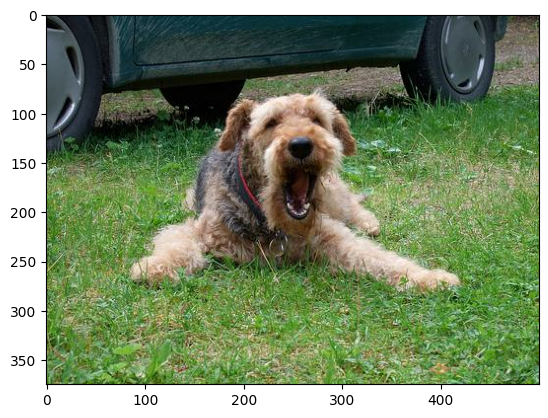

In [11]:
item = get_one(ds_test)
print(item['label']) # 120 개 클라스 중 몇 번인지
plt.imshow(item['image'])
plt.show()

### 5-2.CAM으로 Activation Map 형성

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


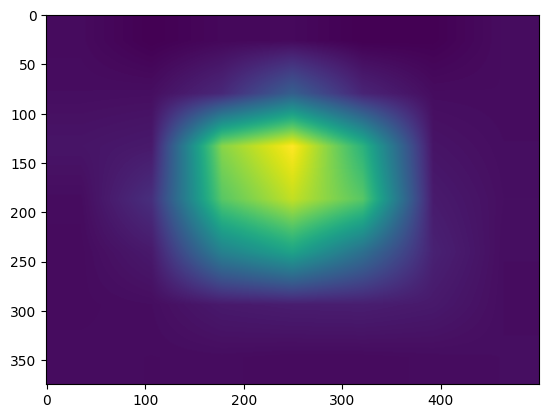

In [12]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

### 5-3.Activation Map이 들어가는 바운딩 박스 생성


In [13]:
rect = get_bbox(cam_image)
rect

array([[113, 107],
       [346,  63],
       [380, 243],
       [148, 287]], dtype=int32)

### 5-4.CAM 바운딩 박스 및 원 이미지 합성

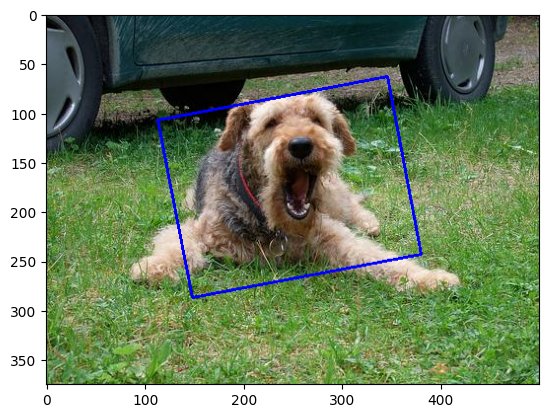

In [14]:
cam_image = copy.deepcopy(item['image'])
cam_image = cv2.drawContours(cam_image, [rect], 0, (0,0,255), 2)
plt.imshow(cam_image)
plt.show()

### 5-5.바운딩 박스 내에서 width, height의 MinMax값의 전체 대비 비율 구하기

In [15]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[np.float64(0.168),
 np.float64(0.226),
 np.float64(0.7653333333333333),
 np.float64(0.76)]

### 5-5.실제 뽑아낸 객체의 width, height의 MinMax값의 전체 대비 비율

In [16]:
item['objects']['bbox']

array([[0.192, 0.168, 0.76 , 0.838]], dtype=float32)

### 5-6.IOU 계산

In [17]:
cam_result = get_iou(pred_bbox, item['objects']['bbox'][0])
cam_result

np.float64(0.7655063196150248)

## 6.Grad CAM 정의, 적용 및 IOU 계산
### 6-1.Grad-CAM 생성

In [18]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)

    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의함.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가함,
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])

    # Gradient를 얻기 위해 tape를 사용함.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))

        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻음.
        output = conv_output[0] # 원하는 layer의 output을 얻음.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻음.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구함.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻음.
        grad_cam_image += w * output[:, :, k]

    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

### 6-2.Grad-CAM Activation Map 생성

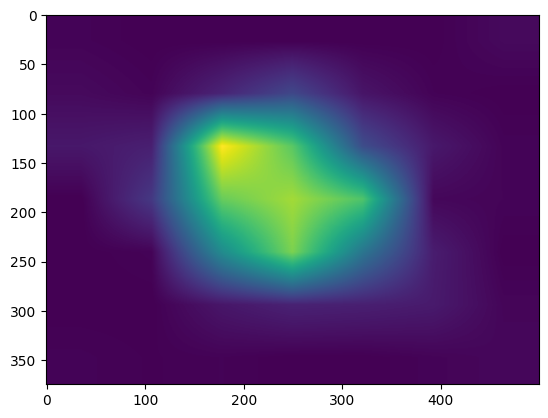

In [19]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

### 6-3.Grad-Cam bbox 영역 구하기

In [20]:
rect = get_bbox(grad_cam_image)
rect

array([[123,  89],
       [363,  89],
       [363, 278],
       [123, 278]], dtype=int32)

### 6-4.Grad-CAM bbox 및 image 합성

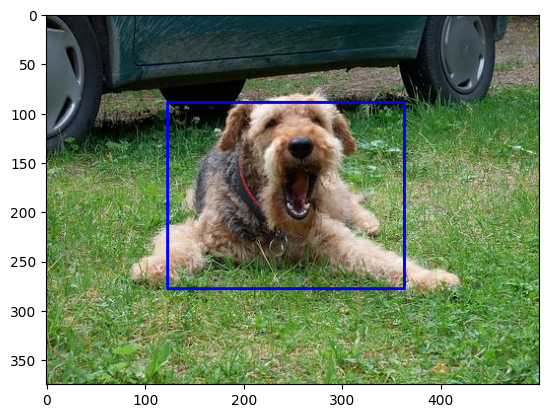

In [21]:
grad_cam_image = copy.deepcopy(item['image'])
grad_cam_image = cv2.drawContours(grad_cam_image, [rect], 0, (0,0,255), 2)
plt.imshow(grad_cam_image)
plt.show()

### 6-5.grad_cam bbox width, height 의 MinMax값 구하기

In [22]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[np.float64(0.23733333333333334),
 np.float64(0.246),
 np.float64(0.7413333333333333),
 np.float64(0.726)]

### 6-6.실제 bbox 비율

In [23]:
item['objects']['bbox']

array([[0.192, 0.168, 0.76 , 0.838]], dtype=float32)

### 6-6.grad_cam의 IOU 계산

In [24]:
grad_cam_result = get_iou(pred_bbox, item['objects']['bbox'][0])
grad_cam_result

np.float64(0.6356947975648801)

## 7.IOU로 성능 비교 및 개별 해석
### 7-1.임의로 100장 뽑아서 성능 비교

In [68]:
# iou, image 저장
cam_result_iou = {}
grad_cam_result_iou = {}
cam_images = {}
grad_cam_images = {}

def get_compare_100(ds_test, cam_result_iou, grad_cam_result_iou, cam_images, grad_cam_images):
    for i in range(100):
        item = get_one(ds_test)
        item_ = copy.deepcopy(item)

        cam_image = generate_cam(cam_model, item)
        cam_rect = get_bbox(cam_image)
        cam_image = copy.deepcopy(item['image'])
        cam_image = cv2.drawContours(cam_image, [cam_rect], 0, (0,0,255), 2)
        cam_pred_bbox = rect_to_minmax(cam_rect, item['image'])
        real_bbox = item['objects']['bbox']
        cam_result = get_iou(cam_pred_bbox, real_bbox[0])
        cam_result_iou[i] = cam_result
        cam_images[i] = cam_image

        grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
        grad_cam_rect = get_bbox(grad_cam_image)
        grad_cam_image = copy.deepcopy(item_['image'])
        grad_cam_image = cv2.drawContours(grad_cam_image, [grad_cam_rect], 0, (0,0,255), 2)
        grad_cam_pred_bbox = rect_to_minmax(grad_cam_rect, item_['image'])
        grad_cam_result = get_iou(grad_cam_pred_bbox, real_bbox[0])
        grad_cam_result_iou[i] = grad_cam_result
        grad_cam_images[i] = grad_cam_image

    return cam_result_iou, grad_cam_result_iou, cam_images, grad_cam_images

In [69]:
cam_iou, grad_cam_iou, cam_images, grad_cam_images = get_compare_100(ds_test, cam_result_iou, grad_cam_result_iou, cam_images, grad_cam_images)

<ipython-input-5-3e7178c24569>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ds = ds.take(int(np.random.randint(1, 20000, 1)))
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


### 7-2.CAM 성능(단순 수치)

In [70]:
print(f"CAM의 가장 낮은 IOU: {min(float(x) for x in cam_result_iou.values()):.2f}")
print(f"CAM의 가장 높은 IOU: {max(float(x) for x in cam_result_iou.values()):.2f}")
print(f"CAM의 평균 IOU: {np.mean(list(map(float, cam_result_iou.values()))):.2f}")

CAM의 가장 낮은 IOU: 0.13
CAM의 가장 높은 IOU: 0.77
CAM의 평균 IOU: 0.36


### 7-3.Grad-CAM 성능(단순 수치)

In [71]:
print(f"Grad-CAM의 가장 낮은 IOU: {min(float(x) for x in grad_cam_result_iou.values()):.2f}")
print(f"Grad-CAM의 가장 높은 IOU: {max(float(x) for x in grad_cam_result_iou.values()):.2f}")
print(f"Grad-CAM의 평균 IOU: {np.mean(list(map(float, grad_cam_result_iou.values()))):.2f}")

Grad-CAM의 가장 낮은 IOU: 0.13
Grad-CAM의 가장 높은 IOU: 0.64
Grad-CAM의 평균 IOU: 0.31


### 7-4.10개 시각화해서 비교

In [72]:
for i in range(20):
    plt.figure(figsize=(10,4))

    plt.subplot(1, 2, 1)
    plt.imshow(cam_images[i])
    plt.title(f"IOU:{cam_iou[i]:.2f}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(grad_cam_images[i])
    plt.title(f"IOU:{grad_cam_iou[i]:.2f}")
    plt.axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## 회고
### 1.CAM과 Grad-CAM이 집중하는 영역이 다르다.
### 3.모델은 Resnet50(fine-tuning)을 사용했는데, 성능이 더 좋은 모델을 쓰면 결과 개선이 될 수도 있겠다.
### 3.실제 어느 영역에 집중하는지 눈으로 확인할 수 있었다.
### 4.CAM의 IOU가 일반적으로 Grad-CAM의 IOU보다 좋았다.
### 5.테스트 셋을 랜덤으로 뽑으니깐 중복이 많았다.